In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
#from torchvision import datasets, transforms
#from complexPyTorch.complexLayers import ComplexBatchNorm2d, ComplexConv2d, ComplexLinear
#from complexPyTorch.complexLayers import ComplexDropout2d, NaiveComplexBatchNorm2d
#from complexPyTorch.complexLayers import ComplexBatchNorm1d
#from complexPyTorch.complexFunctions import complex_relu, complex_max_pool2d

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from scipy.signal import find_peaks, peak_widths

import cvnn.layers as complex_layers

In [2]:
X = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/X_v3.csv', delimiter=',')
Y_c = pd.read_csv('C:/Users/alamg/Desktop/Thesis_ML/matlab/S11_data.csv') #getting complex data
Y = np.genfromtxt('C:/Users/alamg/Documents/MATLAB/Thesis/Targets_v3.csv', delimiter=',') #getting absorbance data

In [3]:
Y_c.shape

(101, 3848)

In [4]:
w1= np.arange(0,3848,1)  
w2=np.arange(0,101,1)
w3=np.linspace(1,101,101)
dP1 = []
dP2 = []
dP3 = []
dA1 = []
dA2 = []
dA3 = []
dQ1 = []
dQ2 =[]
dQ3= []
pos1 = []
pos2 = []
pos3 = []
x_2p_data= pd.DataFrame()
y_2p_data = pd.DataFrame()

In [5]:
##extracting peaks, Q-factor, amp from data
for i in w1:
    peaks, _ = find_peaks(Y[i,:],height=0.4)
    if len(peaks)==1:
      dP1.append(peaks)
      dA1.append(Y[i,(peaks[0])])
      j = peak_widths(Y[i,:], peaks, rel_height=0.5)
      dQ1.append(j[0])
      pos1.append(i)  
    if len(peaks)==2:
        dP2.append(peaks)
        dA2.append(Y[i,(peaks[0],peaks[1])])
        j = peak_widths(Y[i,:], peaks, rel_height=0.5)
        dQ2.append(j[0])
        pos2.append(i) 
    if len(peaks)==3:
        dP3.append(peaks)
        dA3.append(Y[i,(peaks[0],peaks[1],peaks[2])])
        j = peak_widths(Y[i,:], peaks, rel_height=0.5)
        dQ3.append(j[0])
        pos3.append(i)

In [6]:
pos2[2]

5

In [7]:
##extracting 2 peaks responses 
y_2p_wav = []

                                                                                                                            
#getting full waveform for 2 peaks responses
for i in range(0,len(pos2)):
    j = pos2[i]
    y_2p_wav.append(Y[j,:])

y_2p_wav = np.array(y_2p_wav)

z = pd.DataFrame(y_2p_wav)

y_2p_wav.shape

(2087, 101)

In [8]:
#converting pandas to numpy complex data
Y_c = Y_c.to_numpy()
Y_c = Y_c.T


In [9]:
#extracting 2 peaks for complex data 
y_2p_com=[]                                                                                                         
#getting full waveform for 2 peaks responses
for i in range(0,len(pos2)):
    j = pos2[i]
    y_2p_com.append(Y_c[j][:])

In [10]:
y_2p_com = np.array(y_2p_com, dtype=np.complex64)

In [108]:
##saving features in to pandas array
y_2p_data = pd.DataFrame()
#getting data for each peak response by taking y as different pos values for each 1,2,3 peak response

for i in range(0,len(pos2)):
    m = pd.DataFrame({"Peak 1":dP2[i][0],"Peak 2":dP2[i][1],"Amp P1":dA2[i][0],"Amp P2":dA2[i][1],"Q-Factor P1":(dP2[i][0]/dQ2[i][0]),"Q-Factor P2":(dP2[i][1]/dQ2[i][1])},index=[i])
    y_2p_data = pd.concat([y_2p_data, pd.DataFrame(m)], ignore_index=True)

In [12]:
#Getting x data as pandas frame 
x_2p_data = pd.DataFrame()
#getting data for each peak response by taking X as different pos values for each 1,2,3 peak response
for i in range(0,len(pos2)):
    j = pos2[i]
    k = pd.DataFrame({"P1":X[j,0],"H1":X[j,1],"H2":X[j,2],"H3":X[j,3],"W1":X[j,4]},index=[i])
    x_2p_data = pd.concat([x_2p_data, pd.DataFrame(k)], ignore_index=True)

In [13]:
x_2p_data_c = x_2p_data.values.astype(np.complex64)

In [14]:
x_2p_data.head

<bound method NDFrame.head of             P1        H1        H2        H3        W1
0     0.092773  0.161133  0.819336  0.170898  0.430664
1     0.695801  0.854004  0.190918  0.034668  0.794434
2     0.384277  0.665527  0.955566  0.896973  0.525879
3     0.034668  0.409668  0.320801  0.266113  0.734863
4     0.144775  0.390381  0.643311  0.885498  0.577881
...        ...       ...       ...       ...       ...
2082  0.664885  0.505430  0.989183  0.470556  0.642668
2083  0.131681  0.362852  0.205980  0.917822  0.449308
2084  0.097502  0.731016  0.968676  0.049658  0.670988
2085  0.390348  0.556089  0.225145  0.187719  0.870085
2086  0.828581  0.841002  0.067186  0.111792  0.763395

[2087 rows x 5 columns]>

In [15]:
Y_real, Y_imag = np.real(y_2p_com), np.imag(y_2p_com)

In [16]:
Y_all = np.concatenate((Y_real, Y_imag), axis=1) #adding real and imaginary part in one array

In [104]:
Y_all.shape #0 to 101 are real, 101-202 are imaginary 

(2087, 202)

In [18]:
input_shape = (5,)

In [114]:
## To model full waveform for training N.N using y_2p_com
## To model the features of peaks as training dataset for N.N use y_2p_data
X_train, X_test, y_train, y_test = train_test_split(x_2p_data,Y_all, test_size=0.2, random_state=42) #using full waveform data for training dataset

In [117]:
Y_all

array([[ 0.7189003 ,  0.16996944, -0.12681025, ..., -0.41324914,
        -0.5065162 , -0.5888266 ],
       [-0.4927597 , -0.73496974, -0.63856363, ...,  0.0250001 ,
         0.12450028,  0.2216887 ],
       [ 0.76878303,  0.89223504,  0.77684724, ..., -0.6126512 ,
        -0.5747867 , -0.52370447],
       ...,
       [ 0.55045336,  0.7986539 ,  0.7092129 , ..., -0.65134937,
        -0.6300484 , -0.590995  ],
       [ 0.85649437,  0.5240381 ,  0.06151369, ..., -0.8351015 ,
        -0.8039345 , -0.76002526],
       [-0.8370124 , -0.80234706, -0.5775302 , ...,  0.15658501,
         0.253537  ,  0.34662893]], dtype=float32)

In [109]:
y_2p_data.shape

(2087, 6)

In [115]:
#complex ANN
from cvnn.losses import ComplexMeanSquareError

model = tf.keras.models.Sequential()
#model.add(complex_layers.ComplexDense(complex_layers.ComplexInput(input_shape=input_shape[1:]), activation='cart_relu'))
model.add(complex_layers.ComplexInput(input_shape=input_shape))
model.add(complex_layers.ComplexFlatten())
model.add(complex_layers.ComplexDense(units=32, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=64, activation='cart_relu'))
model.add(complex_layers.ComplexDense(units=202, activation='linear'))
model.compile( loss=ComplexMeanSquareError(), optimizer='adam')

In [116]:
model.summary()

model.fit(X_train, y_train, epochs=1000, batch_size=32)  # Replace X_train and Y_train with your actual training data

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_flatten_1 (Complex  (None, 5)                 0         
 Flatten)                                                        
                                                                 
 complex_dense_6 (ComplexDe  (None, 32)                384       
 nse)                                                            
                                                                 
 complex_dense_7 (ComplexDe  (None, 64)                4224      
 nse)                                                            
                                                                 
 complex_dense_8 (ComplexDe  (None, 64)                8320      
 nse)                                                            
                                                                 
 complex_dense_9 (ComplexDe  (None, 64)               

In [118]:
predictions = model.predict(X_test)

14/14 [==============================] - 0s 3ms/step


In [119]:
import joblib 

# save model with joblib 
filename = 'joblib_model.sav'
joblib.dump(model, filename)

['joblib_model.sav']

In [120]:
##doesnt not load complex layers after saving

loaded_model_1 = joblib.load('joblib_model.sav')

# evaluate model 
y_predict = loaded_model_1.predict(X_test)


TypeError: The added layer must be an instance of class Layer. Received: layer=ComplexInput of type <class 'str'>.

In [121]:
#geting absorbance from predicted
abs_pred=[]
for i in range(len(predictions)):
    row = []
    for j in range(len(predictions[0])):
        # Calculate the desired value and append it to the row list
        value = 1 - (abs(predictions[i][j]) ** 2)
        row.append(value)
    # Append the row list to abs_pred
    abs_pred.append(row)

In [122]:
#calculating absorbance of test data
abs_y=[]
for i in range(len(y_test)):
    row = []
    for j in range(len(y_test[0])):
        # Calculate the desired value and append it to the row list
        value = 1 - (abs(y_test[i,j]) ** 2)
        row.append(value)
    # Append the row list to abs_pred
    abs_y.append(row)

In [123]:
#absolute for predicted
pred_abs_d = abs(predictions)

In [124]:
#absolute for ytest
y_test_abs= abs(y_test)

In [125]:
pred_real= predictions.real
pred_comp= predictions.imag

pred_real.shape

(418, 202)

In [126]:
pred_all = np.concatenate((pred_real, pred_comp), axis=1)
pred_all.shape

(418, 404)

C:\Users\alamg\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\alamg\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


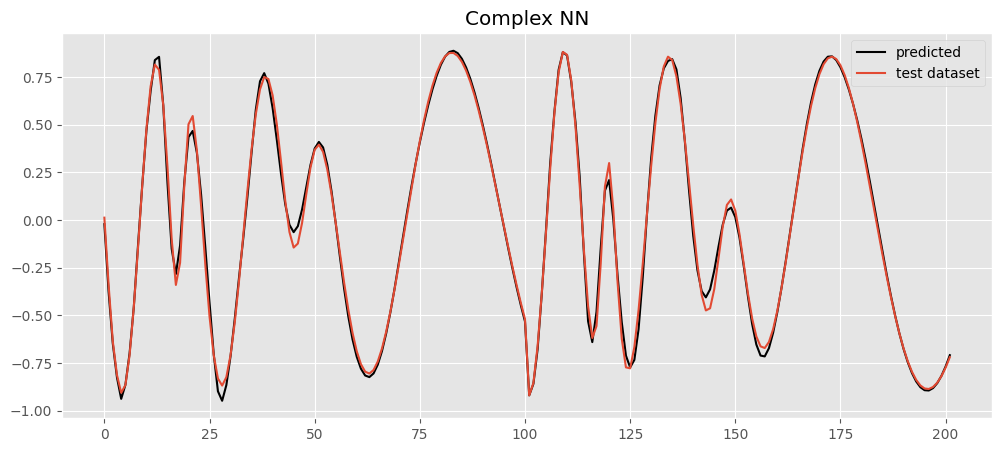

In [138]:
w4=np.arange(0,202,1)
with plt.style.context('ggplot'):#sanity check if correct waveforms are loaded
   # fig, axs = plt.subplots(1, 1, figsize=(12, 5))
   # plt.subplot(1, 2, 1) 
    
    #plt.plot(w3,y_2p_wav[1,:])
   # plt.xlabel("X axis (nm)")
    #plt.ylabel("Y-axis")
   
    plt.plot(w4,predictions[1,:],label='predicted', color='black')
    plt.plot(w4,y_test[1,:], label='test dataset')

    #axs[1].subplot(1,2,2,figsize=(12, 5))
 #   axs[1].plot(w4,predictions[1,:],label='complex', color='black')
  #  axs[1].plot(w4,y_test[1,:], label='absorbance')

   #axs[1].plot(w4,pred_all[1,:],label='predicted', color='blue')
    #axs[1].plot(w4,y_test[1,:], label='test dataset')
    
    plt.title("Complex NN")
   # plt.tight_layout()
    plt.legend()
    plt.show()



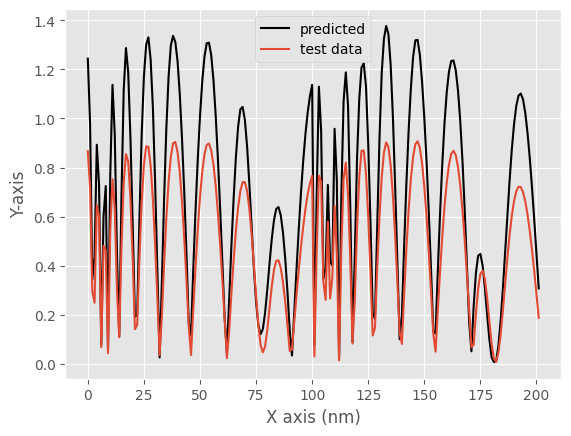

In [132]:
#plotting of absolute data
w4=np.arange(0,202,1)
with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
    plt.plot(w4,pred_abs_d[0,:],label='predicted', color='black')
    plt.plot(w4,y_test_abs[0,:], label='test data')
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()
   

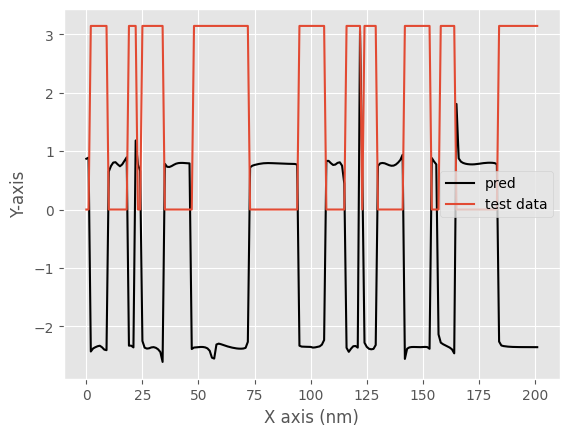

In [131]:
#absorbance reconstructed from predicted data
w4=np.arange(0,202,1)
with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
    plt.plot(w4,np.angle(predictions[5,:]),label='pred', color='black')
    plt.plot(w4,np.angle(y_test[5,:]), label='test data')
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.legend()
    plt.show()
   

In [32]:
#w4=np.arange(0,100,1)
#with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
#    plt.plot(w4,y_2p_com.imag[1,:])
#    plt.plot(w4,predictions.imag[1][:], color = 'black')
#    #plt.plot(w3,y_2p_wav[1,:])
#    plt.xlabel("X axis (nm)")
#    plt.ylabel("Y-axis")
#    plt.show()

In [33]:
y_testp = y_test[:,0:2] #for plotting different Qfactor etc..
predictionsp = predictions[:,0:2]

y_testA = y_test[:,2:4]
predictionsA = predictions[:,2:4]

y_testq = y_test[:,4:6]
predictionsq = predictions[:,4:6]

In [34]:
#non complex model
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [35]:

# Assuming X and Y are your feature and target matrices respectively
# Split the data into training and testing sets
X_train_m2, X_test_m2, y_train_m2, y_test_m2 = train_test_split(x_2p_data,Y_all, test_size=0.2, random_state=42)


# Now X_test contains the testing data
# You can use this X_test to evaluate your trained model

# Create a Sequential model
model_2 = Sequential()

# Add the input layer and the first hidden layer
model_2.add(Dense(32, input_shape=(5,), activation='relu'))  # Assuming 64 neurons in the first hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add additional hidden layers if needed
model_2.add(Dense(64, activation='relu'))  # Example of adding another hidden layer

# Add the output layer
model_2.add(Dense(202, activation='linear'))  # Assuming 5 design parameters, using linear activation

# Compile the model
model_2.compile(optimizer='adam', loss='mse')  # Using mean squared error as the loss function

# Print a summary of the model
model_2.summary()

# Train the model
model_2.fit(X_train_m2, y_train_m2, epochs=1000, batch_size=32)  # Replace X_train and Y_train with your actual training data


# Make predictions
predictions_m2 = model_2.predict(X_test_m2)  # Replace X_test with your actual test data




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 202)               13130     
                                                                 
Total params: 27914 (109.04 KB)
Trainable params: 2791

In [82]:
import joblib 

# save model with joblib 
filename = 'joblib_model_2.sav'
joblib.dump(model_2, filename)

['joblib_model_2.sav']

In [88]:
loaded_model = joblib.load('joblib_model_2.sav')

# evaluate model 
y_predict = loaded_model.predict(X_test_m2)

# check results
print(loaded_model.summary())

14/14 [==============================] - 0s 2ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 202)               13130     
                                                                 
T

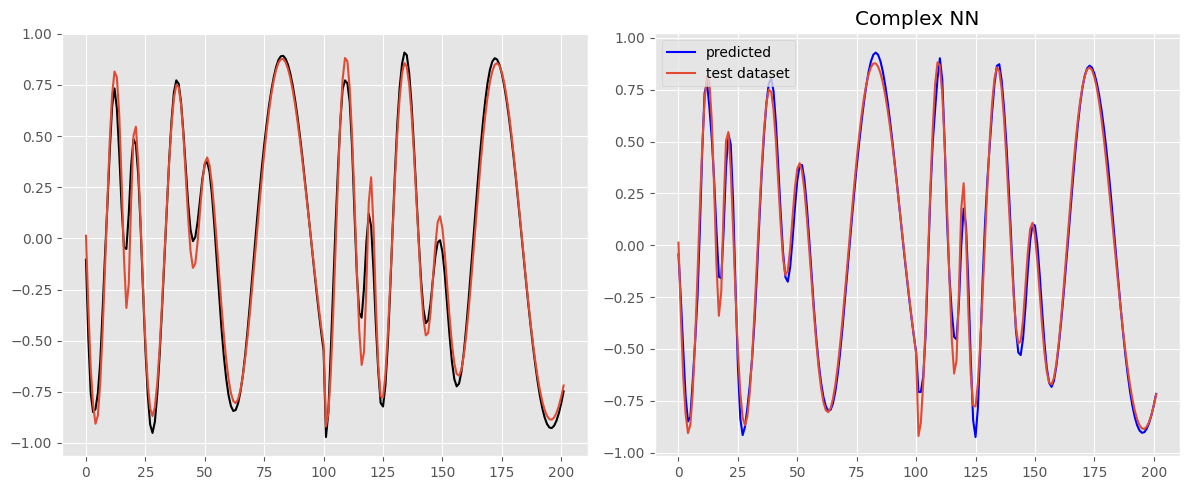

In [56]:
w4=np.arange(0,202,1)
with plt.style.context('ggplot'):#sanity check if correct waveforms are loaded
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
   # plt.subplot(1, 2, 1) 
    
    #plt.plot(w3,y_2p_wav[1,:])
   # plt.xlabel("X axis (nm)")
    #plt.ylabel("Y-axis")
   
    axs[0].plot(w4,predictions_m2[1,:],label='predicted', color='black')
    axs[0].plot(w4,y_test_m2[1,:], label='test dataset')

    #axs[1].subplot(1,2,2,figsize=(12, 5))
 #   axs[1].plot(w4,predictions[1,:],label='complex', color='black')
  #  axs[1].plot(w4,y_test[1,:], label='absorbance')

    axs[1].plot(w4,pred_all[1,:],label='predicted', color='blue')
    axs[1].plot(w4,y_test_m2[1,:], label='test dataset')
    
    plt.title("Complex NN")
    plt.tight_layout()
    plt.legend()
    plt.show()



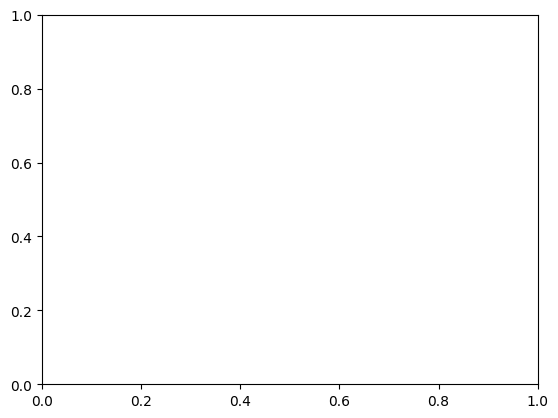

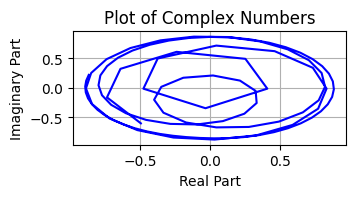

In [94]:
#Boiler plate code for plotting

#complex plot

real_parts = [z.real for z in y_2p_com]
imaginary_parts = [z.imag for z in y_2p_com]

# Plot complex numbers
plt.plot(real_parts[1][:], imaginary_parts[1][:], color='blue')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Plot of Complex Numbers')

# Show plot
plt.grid(True)
#plt.axhline(0, color='black', linewidth=0.5)
#plt.axvline(0, color='black', linewidth=0.5)
plt.show()

C:\Users\alamg\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\alamg\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


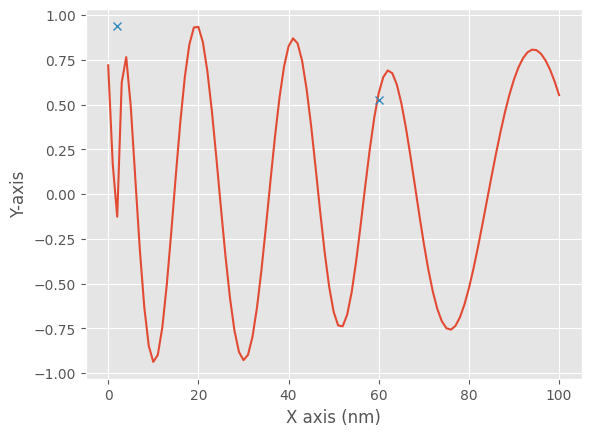

In [95]:
#Boiler plate 

#plot

w4=np.arange(0,101,1)
with plt.style.context('ggplot'): #sanity check if correct waveforms are loaded
    plt.plot(w4,y_2p_com[0,:])
    plt.plot(dP2[0], dA2[0], "x")
    #plt.plot(w3,y_2p_wav[1,:])
    plt.xlabel("X axis (nm)")
    plt.ylabel("Y-axis")
    plt.show()

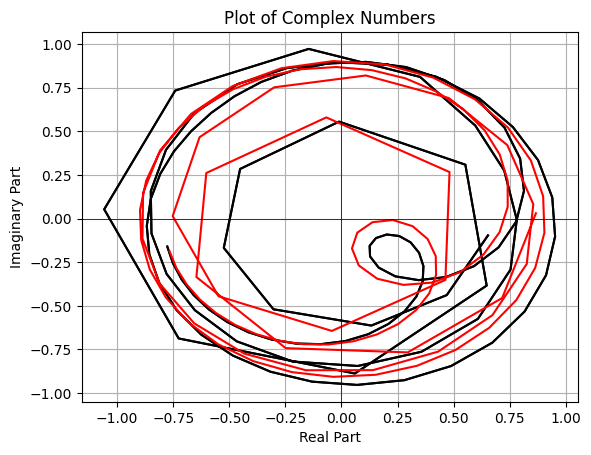

In [101]:
#plotting for 202 data points
real_part = predictions_m2[:,0:101]
imaginary_part =predictions_m2[:,101:202]

real_parts = y_test_m2[:,0:101]
imaginary_parts = y_test_m2[:,101:202]

# Plot complex numbers
plt.plot(real_part[0,:], imaginary_part[0,:], color='black')

# Plot complex numbers
plt.plot(real_parts[0,:], imaginary_parts[0,:], color='red')

# Add labels and title
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Plot of Complex Numbers')

# Show plot
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [102]:
#plotting of Q-factor, Peaks, Amp
num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))



for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testp[i], label='True')
    plt.scatter(Parameters, predictionsp[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Peaks')
    plt.ylabel('Peak Position')
    plt.ylim(0, 1)
    plt.legend()


num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))

for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testA[i], label='True')
    plt.scatter(Parameters, predictionsA[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Amplitude')
    plt.ylabel('Amplitude Value')
    plt.ylim(0, 1.2)
    plt.legend()

num_samples_to_plot = 3
wavelengths_data = pd.DataFrame(np.linspace(1,2,2))
Parameters = wavelengths_data.values.flatten()
plt.figure(figsize=(12, 5))

for i in range(num_samples_to_plot):
    plt.subplot(3, num_samples_to_plot, i + 1)
    plt.scatter(Parameters, y_testq[i], label='True')
    plt.scatter(Parameters, predictionsq[i], label='Predicted')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Peak No')
    plt.ylabel('Q-Factor Scaled')
    plt.ylim(0, 0.5)
    plt.legend()


# Plot the MSE error for each sample


    
plt.tight_layout()
plt.show()

# Plot the MSE error for each sample
mse_errors = ((predictions - y_test)**2).mean(axis=1)

plt.subplot(3, 1, 3)
plt.bar(range(len(mse_errors)), mse_errors)
plt.xlabel('Sample Index')
plt.ylabel('MSE Error')
plt.title('MSE Error for Test Samples')

NameError: name 'y_testp' is not defined